---
title: Combinatorial Optimization with Variational Quantum Algorithms
author:
    - name: Simon Reichert
    - name: Adapted by Adelina Bärligea
date: "2025-11-18"
categories: [code]
image: "preview_image.png"
image-width: "1cm"
image-height: "1cm"
format:
  html:
    embed-resources: true
toc: true
jupyter: blogqa
---

In this tutorial, we demonstrate how to solve combinatorial optimization problems using near-term quantum algorithms, illustrated through the $\mathtt{MaxCut}$ problem. We begin by defining the $\mathtt{MaxCut}$ problem for unweighted graphs, reformulate it as an Ising Hamiltonian, and then solve it using a Variational Quantum Algorithm (VQA) with a hardware-efficient ansatz (HEA).

In [16]:
import tequila as tq
import numpy as np
import networkx as nx

## The $\mathtt{MaxCut}$ Problem

We start out by creating a random graph $G=(V,E)$, defined by its set of vertices $V$ and edges $E$, which will be the basis of our optimization problem. Using the 'networkx' library, we create a graph with $10$ vertices, where every possible edge is created independently with $40\%$ probability, following the Erdös-Rényi random graph model.

In [12]:
problem_size = 10
Graph:nx.Graph = nx.generators.gnp_random_graph(problem_size, 0.4, seed=100)

print("Vertices in Graph: ", Graph.number_of_nodes())
print("Edges in Graph: ", Graph.number_of_edges())

Vertices in Graph:  10
Edges in Graph:  17


![](graph_raw.png){width=60%}

We now define the $\mathtt{MaxCut}$ problem:

Given a graph $G=(V,E)$, a cut is specified by a nontrivial subset $S \subset V$ (i.e., $S \neq \emptyset$ and $S \neq V$). Its value is the number of edges with endpoints on different sides of the partition $S \mid T$, where $T := V \setminus S$:
$$c(S) \;=\; \bigl|\{(i,j)\in E : i\in S,\; j\in T\}\bigr|.$$
Using indicator variables $x_u \in \{0,1\}$ with $x_u=1$ if $u\in S$ and $x_u=0$ otherwise, this can be written as
$$
c(S) := \sum_{\{i,j\}\in E} x_i \oplus x_j
$$
where $\oplus$ denotes XOR, so $x_i \oplus x_j = 1$ exactly when $i$ and $j$ lie in different partitions.

We now want to find a cut with the maximal value ("maximum cut") $$\underset{S\subset V}{\max}\: c(S)$$ which is an NP-hard problem. Solving this exactly therefore quickly becomes infeasible for large graphs, which is why in practice we typically aim for good approximate solutions instead.

For a reasonably small problem instance, as the one above, we can still find its exact solution brute-force, by iterating over all possible cuts and returning the one with the highest value, which is demonstrated in the code below. We visualize the maximum cut via red edges.

In [13]:
def int_to_vertices(s):
    """We use the binary encoding of an integer to represent the different cuts"""
    binary = bin(s)[2:]
    binary = "0" *(problem_size -len(binary)) + binary
    cut = [i for i, j in enumerate(binary) if j== "1"]
    return cut

max_cut, max_cut_value = None, 0
for char_vec in range(1, 2**problem_size - 2):
    cut = int_to_vertices(char_vec)
    value = nx.cuts.cut_size(Graph, cut)
    if value > max_cut_value:
        max_cut, max_cut_value = cut, value

print("Vertices in set S: ", max_cut)
print("Value of this cut:  ", max_cut_value)

Vertices in set S:  [2, 5, 6, 7, 9]
Value of this cut:   13


![](graph_cut.png){width=60%}

## Variational Quantum Algorithms

In the pursuit of finding good approximate solutions to combinatorial optimization problems, such as $\mathtt{MaxCut}$, one promising proposal for near-term quantum hardware is the family of **Variational Quantum Algorithms (VQAs)**.

VQAs combine parametrized quantum circuits (PQCs) with classical parameter optimizers to reduce a cost function, such as the expected cut value. More formally, given a Hamiltonian $H$ which encodes our objective, we seek a state
$$| x^* \rangle = \underset{x}{\operatorname{argmin}} \langle x | H| x \rangle.$$
In a VQA, we prepare a family of quantum states with a PQC $U(\theta)$, namely
$$|\varphi(\theta)\rangle = U(\theta)|0\rangle,$$
and then optimize the parameters $\theta$ such that
$$\theta^* = \underset{\theta}{\operatorname{argmin}} \;\langle \psi(\theta) | H | \psi(\theta) \rangle,$$
to approximate this search.

So the workflow looks like this:

1. Encode your problem's solution into the ground state of a Hamiltonian $H$.

2. Choose a suitable parametrized quantum circuit $U(\theta)$ (the *ansatz*).

3. Measure the expecation value of the cost Hamiltonian $H$ w.r.t. quantum state prepared by $U(\theta)|0\rangle$.

4. Update the parameters $\theta$ using a classical optimizer.

## Solving $\mathtt{MaxCut}$ with VQAs
### Step 1: Encoding into a Hamiltonian

To apply a VQA, we first translate $\mathtt{MaxCut}$ into a Hamiltonian whose ground state corresponds to the maximum cut.

The classical $\mathtt{MaxCut}$ problem asks us to partition the vertex set into two groups such that the number of edges between them is maximized. A cut can be represented by a bitstring $\boldsymbol{x} \in \{0,1\}^n$, where each bit indicates which side of the cut a vertex belongs to.

Quantum states in the computational basis are also indexed by bitstrings, so we can naturally identify a basis state $|\boldsymbol{x}\rangle$ with a candidate cut.

Our goal is to now construct a Hamiltonian $H_C$ such that
$$\langle \boldsymbol{x} | H_C | \boldsymbol{x}\rangle = c(\boldsymbol{x})$$
where $c(\boldsymbol{x})$ counts the number of edges cut by $\boldsymbol{x}$. For each edge ${i,j}\in E$, define the quantum operator
$$\frac{1}{2}(I-Z_iZ_j),$$
with $Z_i$ representing a Pauli-Z matrix applied to the $i$-th qubit. This operator evaluates to $1$ when qubits $i$ and $j$ are in different computational basis states (representing opposite sides of the cut), and $0$ when they are the same. Therefore, a suitable Hamiltonian to represent $\mathtt{MaxCut}$ would be
$$ H_C = \frac{1}{2} \sum_{i,j \in E} (I-Z_iZ_j),$$
which is easily implemented in Tequila.

Finally note, instead of maximizing the expectation of $H_C$, we aim to minimize our loss function, which we therefore define as $H_{\mathrm{cost}}=-H_C$.

In [5]:
H_cost= - 0.5 * Graph.size()
for i,j in Graph.edges:
    H_cost += 0.5 * tq.paulis.Z([i,j])

### Step 2: Defining the ansatz

To generate trial quantum states, we use a hardware-efficient ansatz. This type of ansatz is motivated by near-term quantum devices: it is composed only of gates that are native or easy to implement on common quantum hardware.

The ansatz consists of repeated layers, where each layer applies

1. parameterized single-qubit rotations on every qubit, and
2. a fixed entangling pattern between neighboring qubits.

In our case, each layer applies the rotations
$$ R_x(\theta^{(l)}_i) \quad \text{and} \quad R_y(\theta^{(l)}_i) $$
to qubit $i$ in layer $l$, followed by controlled-$Z$ gates between adjacent qubits. Repeating this pattern for several layers increases the expressiveness of the circuit and allows us to approximate more complex states.

In [7]:
circuit = tq.QCircuit()
layers = 5
for l in range(layers):
    for q in range(problem_size):
        circuit += tq.gates.Rx(tq.Variable(f"Rx_{l}_{q}"), target=q)
        circuit += tq.gates.Ry(tq.Variable(f"Ry_{l}_{q}"), target=q)
    for q in range(problem_size // 2):
        circuit += tq.gates.CZ(2*q, 2* q+1)

    for q in range(problem_size // 2):
        circuit += tq.gates.CZ(2 * q + 1, 2 * q + 2)

![](hea_circuit.png){width=100%}

### Step 3 & 4: Optimizing the objective

With both the parameterized circuit and the cost Hamiltonian in place, we now search for parameters that minimize the energy. This is handled by a classical optimizer, which iteratively updates the circuit parameters based on the measured expectation value.

In this example, we use the BFGS optimizer, a standard gradient-based method. As an initialization strategy, we draw all circuit parameters from a Gaussian distribution with mean $0$ and a small problem-dependent variance.

During the optimization loop, the quantum circuit prepares the state, the expected cost is evaluated, and the classical optimizer updates the parameters until convergence.

In [8]:
exp_value = tq.ExpectationValue(circuit, H_cost)
initial_params = {x: np.random.normal(0, 1) for x in circuit.extract_variables()}
result = tq.minimize(exp_value,
                     method="bfgs",
                     initial_values=initial_params,
                     maxiter=100,
                     silent=True)

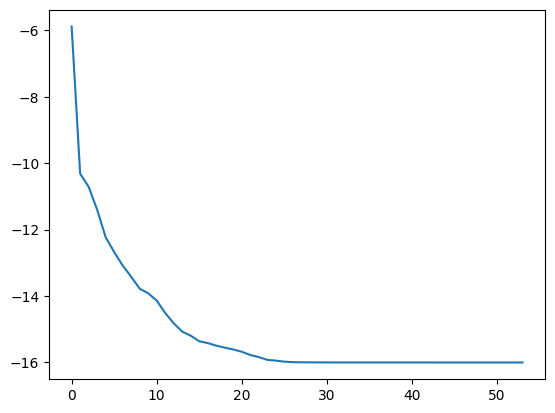

In [7]:
result.history.plot('energies')

We can inspect the wavefunction which is prepared with the optimal parameters. If the optimization was successful, it should be a superposition of only high quality solutions or in case of global convergence, should yield the single maximum cut solution.

In [9]:
wave_fn = tq.simulate(circuit, result.variables, samples=1000)
print(wave_fn)

+179.0000 |01100101010> +821.0000 |01100100010> 


In [14]:
wave_fn = tq.simulate(circuit, result.variables)
cut = int_to_vertices(np.argmax(np.abs(wave_fn.to_array())))
print("Vertices in the found set: ", cut)
print("Value of the cut: ", result.energy)

Vertices in the found cut:  [0, 1, 4, 8]
Optimized cut value:  -12.999944907238435


![](sol_found.png){width=60%}

If we compare this to the maximum cut found with brute-force, we can see that the optimized value here is a good approximation to the true solution.

In [15]:
print("Vertices in set S: ", max_cut)
print("Value of this cut: ", max_cut_value)

Vertices in set S:  [2, 5, 6, 7, 9]
Value of this cut:  13


![](sol_true.png){width=60%}